In [1]:
from eicvibe.utilities.madx_import import *
import yaml
from eicvibe.simulators.xsuite_interface import XSuiteSimulationEngine
from eicvibe.simulators.types import SimulationMode, ParticleDistribution, DistributionType
import numpy as np

In [2]:
data=load_element_types_yaml()
mapping = build_madx_to_eicvibe_mapping(data)


In [3]:
madx_to_eicvibe_type('sBend', mapping)

'Bend'

In [4]:
lattice = lattice_from_madx_file("RCSV4S0.madx", consolidate_drifts_option=True)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2026.02.08 18:26:37      +
  ++++++++++++++++++++++++++++++++++++++++++++
// File generated by: write_lattice_in_foreign_format;

// Bmad lattice file: RCS_Val_test2.bmad;



beam_def: Beam, Particle = Electron, Energy = 0.75, Npart = 0;

option, -info, -echo;

enter Twiss module
  
iteration:   1 error:   4.701828E-09 deltap:   1.000000E-06
orbit:  -7.299439E-12 -1.936889E-14  0.000000E+00  0.000000E+00  1.581802E-08 -4.996508E-09
  
iteration:   1 error:   1.828806E-19 deltap:   0.000000E+00
orbit:  -9.413426E-31 -6.868955E-33  0.000000E+00  0.000000E+00 -1.036721E-17 -9.289997E-32

++++++ table: summ

            length             orbit5               alfa            gammatr 
       1490.386295    1.036720775e-17    0.0006500746395        39.22097522 

                q1      

In [5]:
lattice.elements['cor_1']

Kicker(name=cor_1, type=Kicker, length=0.257, inherit=cor, parameters=[ParameterGroup(name=KickerP, type=KickerP, parameters={'hkick': 0.0, 'vkick': 0.0, 'tilt': 0.0}, subgroups=[])])

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget


((np.float64(-1.4396817071826717e-13), np.float64(9.071808384011891e-13)),
 (np.float64(0.9999999999999897), np.float64(-5.204170427930421e-17)))

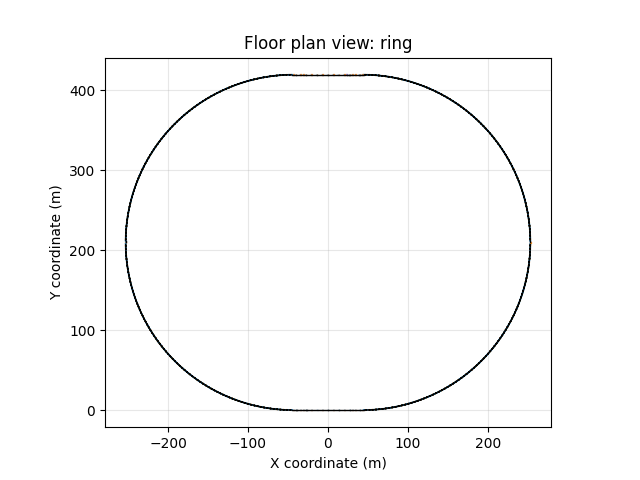

In [7]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
lattice.plot_branch_floorplan('ring', ax)

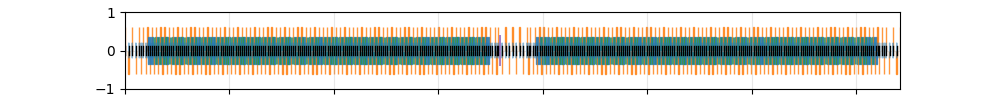

In [8]:
# Test floor plan plotting
fig, ax = plt.subplots(figsize=(10, 1))
#ax.set_aspect('equal')
lattice.plot_branch_beamline('ring', ax)


plt.show()

In [9]:
yaml_dict = lattice.to_yaml_dict()
yaml_str = yaml.dump(yaml_dict, default_flow_style=False)
print(yaml_str)

lattice.get_total_path_length()

elements:
- Quadrupole:
    MagneticMultipoleP:
      kn1: 0.4414675645
    length: 0.235
    name: qfsh
- Monitor:
    length: 0.02
    name: bpm
- Kicker:
    KickerP:
      hkick: 0.0
      tilt: 0.0
      vkick: 0.0
    length: 0.257
    name: cor
- Quadrupole:
    MagneticMultipoleP:
      kn1: -0.4380690037
    length: 0.47
    name: qds
- Quadrupole:
    MagneticMultipoleP:
      kn1: 0.4414675645
    length: 0.47
    name: qfs
- Quadrupole:
    MagneticMultipoleP:
      kn1: 0.4969483914
    length: 0.47
    name: mqf11
- Quadrupole:
    MagneticMultipoleP:
      kn1: -0.4547823656
    length: 0.71
    name: mqd11
- Quadrupole:
    MagneticMultipoleP:
      kn1: 0.5148466767
    length: 0.47
    name: mqf21
- Quadrupole:
    MagneticMultipoleP:
      kn1: -0.5833767677
    length: 0.71
    name: mqd21
- Marker:
    length: 0.0
    name: mend0
- Quadrupole:
    MagneticMultipoleP:
      kn1: 0.531735858
    length: 0.71
    name: qf
- RBend:
    BendP:
      angle: 0.01963495408

1490.3862951058095

In [10]:
# Create and initialize simulation engine
engine = XSuiteSimulationEngine()

# Initialize engine explicitly (creates computation context)
if not engine.initialize_engine():
    raise RuntimeError("Failed to initialize XSuite engine")

# Convert lattice with reference particle setup (IMPROVED API)
xsuite_line = engine.convert_lattice(
    lattice, 
    mode=SimulationMode.RING,
    reference_energy=18e9,       # 18 GeV proton beam
    reference_species="proton",  # Particle type
    bpm_num_turns=500,           # BPM recording duration (turns)
    bpm_frev=1e6                 # Revolution frequency (Hz)
)

print(f"✓ Virtual accelerator initialized")
print(f"  Total length: {xsuite_line.get_length():.2f} m")
print(f"  Number of elements: {len(xsuite_line.element_names)}")
print(f"  Simulation mode: RING")
print(f"  Reference particle: {xsuite_line.particle_ref.p0c[0]/1e9:.2f} GeV proton")

Slicing line:   0%|          | 0/3736 [00:00<?, ?it/s]

✓ Virtual accelerator initialized
  Total length: 1490.39 m
  Number of elements: 35120
  Simulation mode: RING
  Reference particle: 18.00 GeV proton


In [11]:
# Calculate Twiss parameters (optics functions)
# Now possible because reference particle is set!
from eicvibe import TwissData, SimulationMode
import numpy as np

# Get raw XSuite twiss result
xsuite_twiss = xsuite_line.twiss(method='4d')

# Convert to EICViBE package-level TwissData structure
twiss = TwissData(
    s=xsuite_twiss.s,
    beta_x=xsuite_twiss.betx,
    beta_y=xsuite_twiss.bety,
    alpha_x=xsuite_twiss.alfx,
    alpha_y=xsuite_twiss.alfy,
    gamma_x=xsuite_twiss.gamx,
    gamma_y=xsuite_twiss.gamy,
    dx=xsuite_twiss.dx,
    dy=xsuite_twiss.dy,
    dpx=xsuite_twiss.dpx,
    dpy=xsuite_twiss.dpy,
    tune_x=xsuite_twiss.qx,
    tune_y=xsuite_twiss.qy,
    momentum_compaction=xsuite_twiss.momentum_compaction_factor,
    simulation_mode=SimulationMode.RING,
    reference_energy=18e9,
    engine_name="XSuite",
    computation_method="4d"
)

# Display key optics parameters using TwissData
print("✓ Twiss parameters calculated and converted to EICViBE TwissData")
print(f"\nPeriodic solution (RING mode):")
print(f"  Tune X: {twiss.tune_x:.4f}")
print(f"  Tune Y: {twiss.tune_y:.4f}")
print(f"  Momentum compaction: {twiss.momentum_compaction:.6f}")
print(f"\nBeta functions at start:")
print(f"  βx = {twiss.beta_x[0]:.2f} m")
print(f"  βy = {twiss.beta_y[0]:.2f} m")
print(f"\nMax beta functions:")
print(f"  max(βx) = {np.max(twiss.beta_x):.2f} m")
print(f"  max(βy) = {np.max(twiss.beta_y):.2f} m")
print(f"\nData source: {twiss.engine_name} ({twiss.computation_method} method)")

✓ Twiss parameters calculated and converted to EICViBE TwissData

Periodic solution (RING mode):
  Tune X: 43.5369
  Tune Y: 56.6703
  Momentum compaction: 0.000631

Beta functions at start:
  βx = 26.24 m
  βy = 6.72 m

Max beta functions:
  max(βx) = 26.24 m
  max(βy) = 25.82 m

Data source: XSuite (4d method)


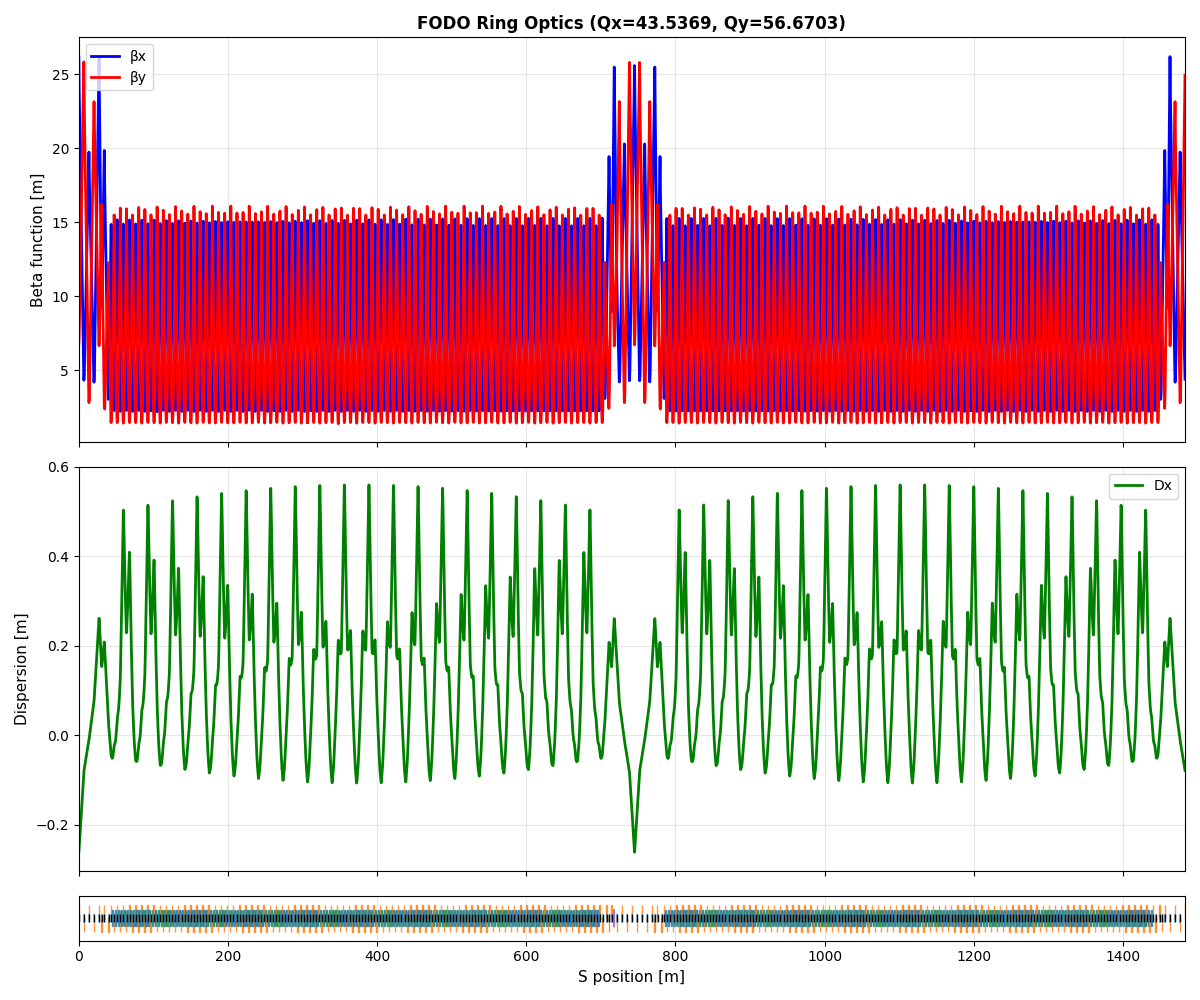

In [12]:
# Plot beta functions, dispersion, and lattice layout
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), 
                                     gridspec_kw={'height_ratios': [9, 9, 1]},
                                     sharex=True)

# Beta functions
ax1.plot(twiss.s, twiss.betx, 'b-', label='βx', linewidth=2)
ax1.plot(twiss.s, twiss.bety, 'r-', label='βy', linewidth=2)
ax1.set_ylabel('Beta function [m]', fontsize=11)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_title(f'FODO Ring Optics (Qx={twiss.qx:.4f}, Qy={twiss.qy:.4f})', fontsize=12, fontweight='bold')

# Dispersion
ax2.plot(twiss.s, twiss.dx, 'g-', label='Dx', linewidth=2)
ax2.set_ylabel('Dispersion [m]', fontsize=11)
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

# Lattice layout (beamline)
lattice.plot_branch_beamline("ring", ax=ax3, start_s=0.0, normalized_strength=None)
ax3.set_xlabel('S position [m]', fontsize=11)
ax3.set_yticks([])  # Remove y-axis ticks
ax3.set_ylabel('')  # Remove y-axis label

plt.tight_layout()
plt.show()

In [13]:
xsuitedicts = xsuite_line.to_dict()

In [14]:
xsuitedicts['elements']

{'qfsh_1': {'__class__': 'Quadrupole',
  'length': np.float64(0.235),
  'k1': np.float64(0.4414675645),
  'order': np.int64(5)},
 'qlo_1': {'__class__': 'Drift', 'length': np.float64(0.055)},
 'bpm_1': {'__class__': 'BeamPositionMonitor',
  'num_particles': np.int64(-1),
  'frev': np.float64(1000000.0),
  'data': {'count': [np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np.float64(0.0),
    np

In [15]:
Length=0.0
for v in xsuitedicts['elements'].values():
    if 'length' in v:
        Length+=v['length']
    if 'Cavity' in v['__class__']:
        print(v)
Length


{'__class__': 'Cavity', 'voltage': np.float64(1120000.0), 'lag': np.float64(180.0), 'frequency': np.float64(563624528.151283)}


np.float64(1490.3862951058095)

In [16]:
# Launch GUI to visualize the RCS lattice with Twiss data
from eicvibe.visualization.gui_app import LatticeViewerGUI
from PyQt5.QtWidgets import QApplication
import sys

import matplotlib.pyplot as plt
plt.ioff()  # Turn off interactive mode
plt.close('all')  # Close all existing figures

# Clear notebook output
from IPython.display import clear_output
clear_output(wait=True)

# Enable Qt event loop in notebook
try:
    from IPython import get_ipython
    ipython = get_ipython()
    if ipython is not None:
        ipython.run_line_magic('gui', 'qt5')
        print("✓ Qt event loop enabled")
except:
    pass

# Create or get QApplication
app = QApplication.instance()
if app is None:
    app = QApplication(sys.argv)

# Create GUI window with lattice and Twiss data
window = LatticeViewerGUI()
window.set_data(lattice=lattice, twiss=twiss, branch_name='ring')
window.show()

print("✓ GUI window launched (separate window)")
print("  - Lattice tab: floor plan (top) and beamline (bottom) views")
print("  - Twiss tab: beta functions, dispersion, and optics parameters")
print("  - Use 'Home' to reset zoom, 'Undo' to go back one zoom level")
print("  - Hover over elements in the floor plan to see tooltips")
print("  - Drag on beamline view to zoom to a specific range")
print("\n⚠ Note: Keep this notebook kernel running to interact with the GUI")

✓ Qt event loop enabled


/Users/haoyue/src/EICViBE/src/eicvibe/visualization/lattice_viewer.py:270: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()
/Users/haoyue/src/EICViBE/src/eicvibe/visualization/lattice_viewer.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()
/Users/haoyue/src/EICViBE/src/eicvibe/visualization/gui_app.py:1594: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.twiss_fig.tight_layout()


✓ GUI window launched (separate window)
  - Lattice tab: floor plan (top) and beamline (bottom) views
  - Twiss tab: beta functions, dispersion, and optics parameters
  - Use 'Home' to reset zoom, 'Undo' to go back one zoom level
  - Hover over elements in the floor plan to see tooltips
  - Drag on beamline view to zoom to a specific range

⚠ Note: Keep this notebook kernel running to interact with the GUI


/Users/haoyue/src/EICViBE/src/eicvibe/visualization/gui_app.py:917: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.twiss_fig.tight_layout()
